In [2]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from scipy import interpolate
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
class WearDataset(Dataset):
    """
    PASS 단위로 데이터를 핸들링 하기 위한 데이터셋
    확장성을 고려하지 않고 동일 조건 데이터셋에만 동작하도록 작성
    다루는 데이터는 Pass는 Test당 15개, Test는 18개로 가정함
    
    """
    def __init__(self, date, usecols, transform=None, root_dir='data',pass_dir_name='split', wear_dir_name='wear', interpolate_option='spl'):
        self.root_dir = root_dir
        self.date = date
        self.usecols = usecols
        base_dir = os.path.join(os.getcwd(), root_dir, date)
        self.pass_dir = os.path.join(base_dir, pass_dir_name)
        
        wear_fname = f'wear_{date}_{interpolate_option}.npy'
        self.wear_path = os.path.join(base_dir, wear_dir_name, wear_fname)
        self.y = np.load(self.wear_path)
        
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.pass_dir)) # pass의 개수
    
    def __getitem__(self, idx):
        """
        idx+1번째 pass의 데이터를 리턴한다.
        -> pass단위로 파일을 잘라서 그때그때 idx에 따라 불러오는건?
        
        returns
            X(dataframe) : idx에 대응하는 Pass 데이터
            y(ndarray) : X에 대응하는 interpolate 된 VBMax값
        """
        idx = idx+1
    
        if idx > len(self):
            raise IndexError('Index out of range')
        
        # pass_idx starts with 1
        f_name = f'{self.date}_{idx}.ftr'
        f_path = os.path.join(self.pass_dir, f_name)
        X = pd.read_feather(f_path, columns=self.usecols)[self.usecols]
        
        # interpolated wear_idx also starts with 1
        y = self.y[idx]
        
        data = {'X':X, 'y':y}
        
        # transfom
        if self.transform:
            data = self.transform(data)
        
        return data
        
    

In [4]:
import pickle

class StatisticalTransform(object):
    """
    주어진 데이터를 평균, 분산, 왜도, 첨도 등의 통계량으로 요약합니다.
    """
    def __init__(self):
        pass
    
    def __call__(self, data):
        X, y = data['X'], data['y']
        
        rows, cols = X.shape

        features = X.columns.tolist()
        res = {}
        stat_names = ['mean', 'std', 'median', 'min', 'max', 'skew', 'kurtosis']
        for f_name in features:
            col = X[f_name]
            stats = [col.mean(), col.std(), np.median(col), col.min(), col.max(), col.skew(), col.kurtosis()]

            for s_name, stat in zip(stat_names, stats):
                res[f'{f_name}-{s_name}'] = [stat]
        
        df = pd.DataFrame(res)
        
        return {'X':df, 'y':y}
    
class ScalerTransform(object):
    """
    미리 fitting 되어있는 standardscaler를 이용하여 transform을 진행합니다.
    """
    def __init__(self, scaler_path, to_numpy=False):
        
        self.path = scaler_path
        self.to_numpy = to_numpy
        with open(self.path, 'rb') as f:
            self.scaler = pickle.load(f)
        
    def __call__(self, data):
        X, y = data['X'], data['y']
        
        scaled_X = self.scaler.transform(X.values)
        
        if self.to_numpy:
            pass
        else:
            scaled_X = pd.DataFrame(scaled_X, index=X.index, columns=X.columns)
        
        return {'X':scaled_X, 'y':y}
        
    
class WaveletTransform(object):
    """
    주어진 데이터를 웨이블릿 변환하여 특정 통계량으로 요약합니다.
    Args :
        method('str') : 변환할 통계량
                        기본적으로 MAD값을 사용합니다.
    """
    def __init__(self, method):
        self.method = method
        pass
    
    def __call__(self, data):
        X, y = data['X'], data['y']
        
        # do something
        raise NotImplementedError()
        
        return {'X':X, 'y':y}
    
class FastFurierTransform(object):
    """
    주어진 데이터에 대하여 고속 푸리에 변환을 수행합니다.
    """
    def __init__(self):
        pass
    
    def __call__(self, data):
        X, y = data['X'], data['y']
        
        # do something
        raise NotImplementedError()
        
        return {'X':X, 'y':y}

class ToNumpy(object):
    def __call__(self, data):
        X, y = data['X'], data['y']
            
        return {'X':X.values, 'y':y}
    
class ToTensor(object):
    """numpy array를 tensor(torch)로 변환 시켜줍니다."""

    def __call__(self, data):
        X, y = data['X'], data['y']
            
        return {'X':torch.from_numpy(X.values), 'y':torch.from_numpy(y)}
    
class LogYTransform(object):
    def __call__(self, data):
        X, y = data['X'], data['y']
        
        return {'X' : X, 'y':np.log(y)}

In [5]:
# 절삭력 제거
usecols = [
 'x_acceleration',
 'y_acceleration',
 'sound',
 'voltage_r',
 'voltage_s',
 'voltage_t',
 'current_r',
 'current_s',
 'current_t',
 'x_position',
 'x_load',
 'x_current',
 'y_position',
 'y_load',
 'y_current',
 'z_load',
 'z_current']

In [6]:
def load_dataloader(exp_name='d3', transformer=None):
    standard_scaler_path = os.path.join('utils', 'scaler', f'{exp_name}_standard_scaler.pkl')
    
    if transformer is None:
        transformer = transforms.Compose([ScalerTransform(standard_scaler_path), StatisticalTransform(),ToNumpy()])

    D3 = WearDataset('5_07', usecols, transform=transformer)
    D5 = WearDataset('6_24', usecols, transform=transformer)
    D6 = WearDataset('6_28', usecols, transform=transformer)
    D10 = WearDataset('9_17', usecols, transform=transformer)

    # dataset for experiment d3
    if exp_name == 'd3':
        train_datasets = [D5, D10]
        test_datasets = [D3]
        validation_datasets = [D6]
    elif exp_name == 'd5':
        train_datasets = [D3, D10]
        test_datasets = [D5]
        validation_datasets = [D6]
    elif exp_name == 'd10':
        train_datasets = [D3, D5]
        test_datasets = [D10]
        validation_datasets = [D6]

    train_dataset = torch.utils.data.ConcatDataset(train_datasets) 
    test_dataset = torch.utils.data.ConcatDataset(test_datasets) 
    validation_dataset = torch.utils.data.ConcatDataset(validation_datasets) 
    # DataLoader를 사용하기 위해서는 데이터가 numpy array/ tensor 형식이여야 함(dataframe 사용 안됨)
    train_loader = DataLoader(train_dataset,batch_size=2,shuffle=True) 
    validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    return train_loader, validation_loader, test_loader

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(119,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 119)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
      
        x = self.fc4(x)
        return x.view(-1)

In [8]:
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(119, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, 119)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

In [9]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [10]:
print(DEVICE)

cuda


In [10]:
def train(model, train_loader, optimizer): # 1epoch만큼 학습시킴
    model.train() # 학습 모드로 변경. 드롭아웃 등 train에서만 적용되는 옵션들이 적용됨
    
    for batch_idx, wear in enumerate(train_loader):
        data, target = wear['X'].float().to(DEVICE), wear['y'].float().to(DEVICE) # data와 target을 DEVICE로 보냄 (cuda or cpu)
     
        optimizer.zero_grad() # 파라미터의 grad를 0으로 만들어줌
        output = model(data)
        loss = F.mse_loss(output, target)
#         print(batch_idx, loss)
        loss.backward()
        optimizer.step()
        
    y_pred = list()
    y_true = list()
    model.eval()
    with torch.no_grad():
        for wear in train_loader:
            data, target = wear['X'].float().to(DEVICE), wear['y'].float().to(DEVICE)
            output = model(data)
            for o in output.to('cpu').numpy():
                y_pred.append(o)
                
            for t in target:
                y_true.append(t)
    
    return y_pred, y_true

def evaluate(model, test_loader):
    model.eval()
    y_pred = list()
    y_true = list()
    test_loss = 0

    with torch.no_grad(): # 기울기 계산을 하지 않음
        for wear in test_loader:
            data, target = wear['X'].float().to(DEVICE), wear['y'].float().to(DEVICE)
            output = model(data)
            y_pred.append(output.item())
            y_true.append(target.item())
            loss = F.mse_loss(output, target, reduction='sum').item()
            test_loss += loss
    mse_avg = test_loss / len(test_loader)
    return y_pred, y_true

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
def experiment(train_loader, val_loader, test_loader, epoch=20):
    
    model = Net().to(DEVICE) # to() : 어디서 연산을 할지 정할 수 있음. 모델의 가중치를 DEVICE로 보냄
    print(model)
    learning_rate = 1e-2
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    for epoch in range(epoch):
        y_pred_train, y_true_train = train(model, train_loader, optimizer)
        train_loss = mean_squared_error(y_true_train, y_pred_train)
        train_losses.append(train_loss)
        
        y_pred_val, y_true_val = evaluate(model, validation_loader)
        val_loss = mean_squared_error(y_true_val, y_pred_val)
        val_losses.append(val_loss.item())
        
        print('epoch',epoch, 'train_loss:', train_loss, 'val_loss:',val_loss)
        
    y_pred, y_true = evaluate(model, test_loader)
    
    return train_losses, val_losses, y_pred, y_true, model

In [11]:
# logtransform
# log_transformer = transforms.Compose([ScalerTransform(standard_scaler_path), StatisticalTransform(), LogYTransform(),ToNumpy()])
train_loader, validation_loader, test_loader = load_dataloader(exp_name='d3', transformer=None)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
train_loader


In [15]:
train_losses, val_losses, y_pred, y_true, model = experiment(train_loader, validation_loader, test_loader, epoch=30)

Net(
  (fc1): Linear(in_features=119, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


KeyboardInterrupt: 

In [20]:
train_losses

NameError: name 'train_losses' is not defined

In [57]:
import matplotlib.pyplot as plt

def plot_validation_curve(train_losses, validation_losses):
    assert len(train_losses) == len(validation_losses)
    
    epoch = len(train_losses)
    
    plt.figure(figsize=(16,8))
    
    plt.title('Validation Curve')
    plt.plot(range(1, epoch+1), train_losses, label='train_loss')
    plt.plot(range(1, epoch+1), validation_losses, label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_prediction(y_true, y_pred):
    plt.figure(figsize=(16,8))
    passes = len(y_true)
    plt.title('Prediction Curve')
    plt.plot(range(1, passes+1), y_true, 'o', label='y_true')
    plt.plot(range(1, passes+1), y_pred, 'o',label='y_pred')
    plt.xlabel('Pass')
    plt.ylabel('VBmax(um)')
    plt.legend()
    plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_metrics(y_pred, y_true):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r_square = r2_score(y_true, y_pred)
    
    return rmse, mape, r_square

In [ ]:
EPOCHS = 20
BATCH_SIZE = 64

In [25]:
model = Net().to(DEVICE) # to() : 어디서 연산을 할지 정할 수 있음. 모델의 가중치를 DEVICE로 보냄

In [26]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=0.000001)

In [27]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc1.weight tensor([[ 0.0827, -0.0717, -0.0096,  ...,  0.0120, -0.0820,  0.0588],
        [-0.0305,  0.0336,  0.0606,  ...,  0.0520, -0.0543,  0.0763],
        [ 0.0033,  0.0021, -0.0623,  ...,  0.0179,  0.0424,  0.0459],
        ...,
        [ 0.0477,  0.0148,  0.0466,  ...,  0.0497,  0.0823, -0.0533],
        [-0.0049, -0.0410,  0.0760,  ...,  0.0609,  0.0907,  0.0601],
        [ 0.0660,  0.0533,  0.0124,  ..., -0.0211, -0.0074, -0.0361]],
       device='cuda:0')
fc1.bias tensor([-3.7685e-02,  3.8160e-02, -4.1242e-03,  3.7054e-02,  5.8663e-02,
        -2.2212e-02, -3.4103e-02,  7.2521e-02, -8.7200e-02, -1.1020e-02,
        -3.0434e-02,  6.1183e-02,  5.2330e-02,  4.4048e-02,  3.5811e-02,
         6.2953e-02, -3.3086e-02, -2.7141e-02, -5.7668e-02,  8.8898e-02,
         2.5654e-02, -8.1511e-02,  1.4289e-02,  5.6228e-02, -4.8041e-02,
        -1.6412e-02,  5.4702e-02, -6.8928e-02, -6.6193e-02, -4.9782e-03,
         7.5938e-02, -1.5211e-02, -1.4640e-02, -5.3393e-02, -2.1307e-02,
         3.

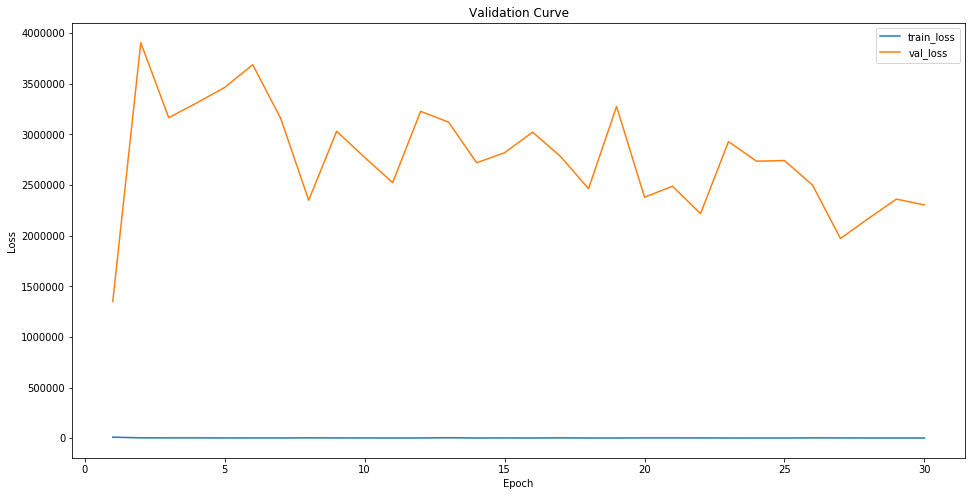

In [58]:
plot_validation_curve(train_losses, val_losses)

In [59]:
get_metrics(y_pred, y_true)

(143.17718444161363, 41.76165399922615, 0.7323877332924715)

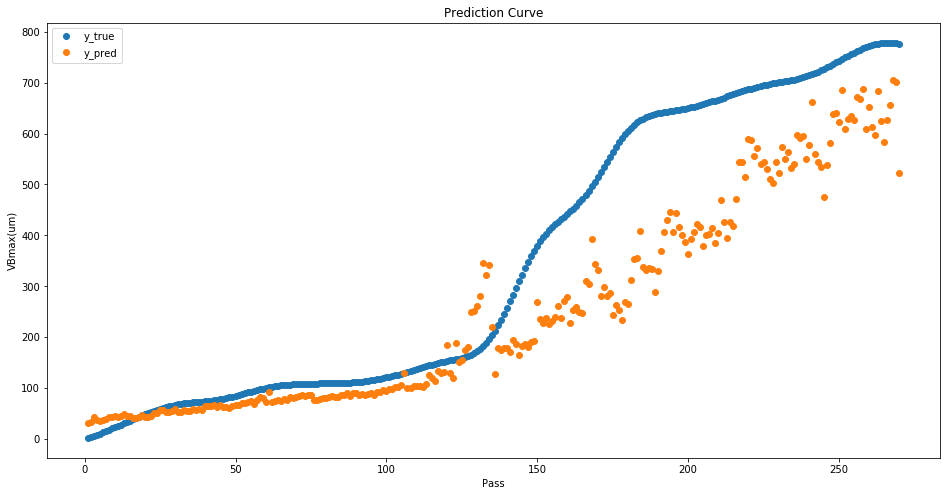

In [60]:
plot_prediction(y_true, y_pred)